In [ ]:
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [ ]:
pip install --upgrade transformers

In [ ]:
!pip install datasets

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader ,Dataset
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.nn.utils.rnn import pad_sequence
import math

In [ ]:
dataset = load_dataset("dair-ai/emotion")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [ ]:
dic = {i:k for i,k in enumerate(dataset["train"].features["label"].names)}

In [ ]:
dic

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [ ]:
decode = lambda l:[dic[x] for x in l]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
class InputEmbedding(nn.Module):
  def __init__(self , d_embed , vocab_size , seq_len):

    super().__init__()

    self.embedding = nn.Embedding(vocab_size , d_embed)
    self.positional = nn.Embedding(seq_len,d_embed)

  def forward(self,x,device):
    B,T = x.shape
    return self.positional(torch.arange(T,device=device)) + self.embedding(x)

In [ ]:
class FeedForwardBlock(nn.Module):

  def __init__(self,d_embed,dropout:float):
    super().__init__()

    self.linear1 = nn.Linear(d_embed , d_embed*4)
    self.linear2 = nn.Linear(d_embed*4 , d_embed)
    self.dropout = nn.Dropout(dropout)

  def forward(self,x):
    return self.linear2(self.dropout(torch.relu(self.linear1(x))))

In [ ]:
class LayerNormalization(nn.Module):

  def __init__(self , eps:float=10**-6):
    super().__init__()

    self.eps = eps
    self.alpha = nn.Parameter(torch.ones(1))
    self.bias = nn.Parameter(torch.zeros(1))

  def forward(self,x):
    mean = x.mean(dim=-1,keepdim=True)
    std = x.std(dim=-1,keepdim=True)
    return self.alpha *(x-mean)/(std+self.eps) + self.bias

In [ ]:
class ResidualConnection(nn.Module):

  def __init__(self,dropout:float):
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.norm = LayerNormalization()

  def forward(self,x,sublayer):
    return x + self.dropout(sublayer(self.norm(x)))

In [ ]:
class MultiHeadAttentionBlock(nn.Module):
  def __init__(self,d_embed , n_head  , dropout:float):
    super().__init__()

    self.d_embed = d_embed
    self.n_head = n_head

    self.query = nn.Linear(d_embed , d_embed)
    self.key = nn.Linear(d_embed , d_embed)
    self.value = nn.Linear(d_embed , d_embed)

    self.d_em = d_embed//n_head


    self.out = nn.Linear(d_embed , d_embed)

    self.dropout = nn.Dropout(dropout)

  def attention(self,query,key,value,dropout:nn.Dropout):

    d_em = query.shape[-1]


    attention_scores = (query @ key.transpose(-2,-1))/math.sqrt(d_em)

    attention_scores = attention_scores.softmax(dim=-1)

    if dropout is not None:
      attention_scores = dropout(attention_scores)

    return (attention_scores @ value)

  def forward(self,query,key,value):

    B,T,C = query.shape
    query = self.query(query)
    key = self.key(key)
    value = self.value(value)


    query = query.view(query.shape[0],query.shape[1],self.n_head,self.d_em).transpose(1,2)
    key = key.view(key.shape[0],key.shape[1],self.n_head,self.d_em).transpose(1,2)
    value = value.view(value.shape[0],value.shape[1],self.n_head,self.d_em).transpose(1,2)

    x = self.attention(query,key,value,self.dropout)

    x = x.transpose(1,2).contiguous().view(x.shape[0],-1,self.n_head*self.d_em)

    return self.out(x)

In [ ]:
class EncoderBlock(nn.Module):

  def __init__(self,self_attention_block:MultiHeadAttentionBlock , feed_forward_block:FeedForwardBlock , dropout:float):
    super().__init__()

    self.self_attention_block = self_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])


  def forward(self,x):

    x = self.residual_connections[0](x,lambda x:self.self_attention_block(x,x,x))
    x = self.residual_connections[1](x,self.feed_forward_block)

    return x

In [ ]:
class ProjectionLayer(nn.Module):

  def __init__(self,d_model:int , num_classes:int):
    super().__init__()

    self.proj = nn.Linear(d_model,num_classes)

  def forward(self,x):
    x = x[:,0,:]
    return self.proj(x)

In [ ]:
class Encoder(nn.Module):

  def __init__(self,layers:nn.ModuleList):

    super().__init__()

    self.layers = layers
    self.norm = LayerNormalization()

  def forward(self,x):
    for layer in self.layers:
      x = layer(x)
    return self.norm(x)

In [ ]:
class ClassificationModel(nn.Module):

  def __init__(self, encoder:Encoder , projection_layer: ProjectionLayer , source_embed:InputEmbedding,device):
    super().__init__()

    self.encoder = encoder
    self.projection_layer = projection_layer
    self.source_embed = source_embed
    self.device = device

  def encode(self,source):

    source = self.source_embed(source,self.device)
    return self.encoder(source)

  def project(self, x):
    return self.projection_layer(x)


In [ ]:
def BuildModel(d_model:int , n_heads:int , vocab_size:int,num_classes:int , N:int , dropout:float,block_size:int,device):

  source_embed = InputEmbedding(d_model, vocab_size,block_size)

  blocks = []
  for _ in range(N):
    self_attention_block = MultiHeadAttentionBlock(d_model, n_heads, dropout)
    feed_forward_block = FeedForwardBlock(d_model, dropout)
    encoder_block = EncoderBlock(self_attention_block, feed_forward_block, dropout)
    blocks.append(encoder_block)
  encoder = Encoder(nn.ModuleList(blocks))

  projection_layer = ProjectionLayer(d_model, num_classes)

  classification_model = ClassificationModel(encoder,projection_layer,source_embed,device)

  return classification_model


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
import os
def save_checkpoint(model, optimizer, epoch, path):

    directory = os.path.dirname(path)
    if not os.path.exists(directory):
          os.makedirs(directory)

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }

    torch.save(checkpoint, path)

    print(f"Checkpoint saved at epoch {epoch}")

In [ ]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
emotions_encoded = dataset.map(tokenize, batched=True, batch_size=128)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotions_encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [ ]:
batch_size = 128
block_size = 256
n_epochs = 30
learning_rate = 3e-4
d_embed = 768
n_head = 6
n_layer = 6
dropout = 0.2
vocab_size=len(tokenizer.get_vocab())
num_classes = 6

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataset = emotions_encoded["train"]
val_dataset = emotions_encoded["validation"]
test_dataset = emotions_encoded["test"]

train_loader = DataLoader(train_dataset,batch_size=batch_size)
val_loader = DataLoader(val_dataset,batch_size=batch_size)
test_loader = DataLoader(test_dataset,batch_size=batch_size)

model = BuildModel(d_model=d_embed, n_heads=n_head, vocab_size=vocab_size,num_classes=num_classes, N=n_layer, dropout=dropout,block_size=block_size,device=device).to(device)
print(count_parameters(model))
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(n_epochs):

  model.train()
  train_loss = 0
  val_loss = 0

  for batch in tqdm(train_loader):

    source = batch["input_ids"].to(device)
    target = batch["label"].to(device)

    encode = model.encode(source)
    prob = model.project(encode)

    prob = prob.view(-1, num_classes)

    targets = target.view(-1)
    loss = loss_fn(prob, targets)


    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  print(f"Epoch {epoch + 1}/{n_epochs}, Training Loss: {train_loss / len(train_loader)}")

  model.eval()
  with torch.no_grad():
    for batch in tqdm(val_loader):

      source = batch["input_ids"].to(device)
      target = batch["label"].to(device)

      encode = model.encode(source)
      prob = model.project(encode)

      prob = prob.view(-1, num_classes)
      targets = target.view(-1)
      loss = loss_fn(prob, targets)

      val_loss += loss.item()

  print(f"Epoch {epoch + 1}/{n_epochs},  Validation Loss: {val_loss / len(val_loader)}")
  if epoch+1 == 15:
   save_checkpoint(model, optimizer, epoch + 1, f"/content/drive/MyDrive/checkpoint/textclassification_epoch_{epoch + 1}.pth")



64978976


100%|██████████| 125/125 [01:15<00:00,  1.65it/s]


Epoch 1/30, Training Loss: 1.6965886583328247


100%|██████████| 16/16 [00:03<00:00,  4.99it/s]


Epoch 1/30,  Validation Loss: 1.593594878911972


100%|██████████| 125/125 [01:19<00:00,  1.57it/s]


Epoch 2/30, Training Loss: 1.5587135829925538


100%|██████████| 16/16 [00:03<00:00,  4.81it/s]


Epoch 2/30,  Validation Loss: 1.4759745225310326


100%|██████████| 125/125 [01:21<00:00,  1.53it/s]


Epoch 3/30, Training Loss: 1.1826652421951294


100%|██████████| 16/16 [00:03<00:00,  4.71it/s]


Epoch 3/30,  Validation Loss: 0.8581961542367935


100%|██████████| 125/125 [01:22<00:00,  1.51it/s]


Epoch 4/30, Training Loss: 0.6350643138885498


100%|██████████| 16/16 [00:03<00:00,  4.69it/s]


Epoch 4/30,  Validation Loss: 0.5168892070651054


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


Epoch 5/30, Training Loss: 0.39048235154151917


100%|██████████| 16/16 [00:03<00:00,  4.68it/s]


Epoch 5/30,  Validation Loss: 0.44728254340589046


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


Epoch 6/30, Training Loss: 0.291388277888298


100%|██████████| 16/16 [00:03<00:00,  4.70it/s]


Epoch 6/30,  Validation Loss: 0.45405085012316704


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


Epoch 7/30, Training Loss: 0.2722219605445862


100%|██████████| 16/16 [00:03<00:00,  4.67it/s]


Epoch 7/30,  Validation Loss: 0.45439057797193527


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


Epoch 8/30, Training Loss: 0.22746316361427307


100%|██████████| 16/16 [00:03<00:00,  4.70it/s]


Epoch 8/30,  Validation Loss: 0.4456072077155113


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


Epoch 9/30, Training Loss: 0.19806410706043243


100%|██████████| 16/16 [00:03<00:00,  4.69it/s]


Epoch 9/30,  Validation Loss: 0.4270908562466502


100%|██████████| 125/125 [01:22<00:00,  1.51it/s]


Epoch 10/30, Training Loss: 0.19298107677698134


100%|██████████| 16/16 [00:03<00:00,  4.72it/s]


Epoch 10/30,  Validation Loss: 0.44735515769571066


100%|██████████| 125/125 [01:22<00:00,  1.51it/s]


Epoch 11/30, Training Loss: 0.16958542016148567


100%|██████████| 16/16 [00:03<00:00,  4.68it/s]


Epoch 11/30,  Validation Loss: 0.4684094339609146


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


Epoch 12/30, Training Loss: 0.18693748182058334


100%|██████████| 16/16 [00:03<00:00,  4.72it/s]


Epoch 12/30,  Validation Loss: 0.5288233682513237


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


Epoch 13/30, Training Loss: 0.3723257384300232


100%|██████████| 16/16 [00:03<00:00,  4.70it/s]


Epoch 13/30,  Validation Loss: 0.5265899728983641


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


Epoch 14/30, Training Loss: 0.35640753257274627


100%|██████████| 16/16 [00:03<00:00,  4.66it/s]


Epoch 14/30,  Validation Loss: 0.5041968710720539


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


Epoch 15/30, Training Loss: 0.29346089655160906


100%|██████████| 16/16 [00:03<00:00,  4.70it/s]


Epoch 15/30,  Validation Loss: 0.525150254368782
Checkpoint saved at epoch 15


100%|██████████| 125/125 [01:22<00:00,  1.51it/s]


Epoch 16/30, Training Loss: 0.27430476498603823


100%|██████████| 16/16 [00:03<00:00,  4.64it/s]


Epoch 16/30,  Validation Loss: 0.4282695911824703


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


Epoch 17/30, Training Loss: 0.2390117437839508


100%|██████████| 16/16 [00:03<00:00,  4.72it/s]


Epoch 17/30,  Validation Loss: 0.4133280050009489


100%|██████████| 125/125 [01:21<00:00,  1.53it/s]


Epoch 18/30, Training Loss: 0.20240289545059204


100%|██████████| 16/16 [00:03<00:00,  4.71it/s]


Epoch 18/30,  Validation Loss: 0.44240165315568447


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


Epoch 19/30, Training Loss: 0.2017132412791252


100%|██████████| 16/16 [00:03<00:00,  4.67it/s]


Epoch 19/30,  Validation Loss: 0.42946051619946957


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


Epoch 20/30, Training Loss: 0.2112849564552307


100%|██████████| 16/16 [00:03<00:00,  4.69it/s]


Epoch 20/30,  Validation Loss: 0.4822231577709317


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


Epoch 21/30, Training Loss: 0.3076736162900925


100%|██████████| 16/16 [00:03<00:00,  4.69it/s]


Epoch 21/30,  Validation Loss: 0.5109005235135555


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


Epoch 22/30, Training Loss: 0.37887068223953246


100%|██████████| 16/16 [00:03<00:00,  4.72it/s]


Epoch 22/30,  Validation Loss: 0.4612946379929781


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


Epoch 23/30, Training Loss: 0.31081592476367953


100%|██████████| 16/16 [00:03<00:00,  4.65it/s]


Epoch 23/30,  Validation Loss: 0.4763197097927332


100%|██████████| 125/125 [01:22<00:00,  1.51it/s]


Epoch 24/30, Training Loss: 0.277919784784317


100%|██████████| 16/16 [00:03<00:00,  4.71it/s]


Epoch 24/30,  Validation Loss: 0.5209999699145555


100%|██████████| 125/125 [01:21<00:00,  1.53it/s]


Epoch 25/30, Training Loss: 0.26158314156532286


100%|██████████| 16/16 [00:03<00:00,  4.71it/s]


Epoch 25/30,  Validation Loss: 0.498765267431736


100%|██████████| 125/125 [01:21<00:00,  1.52it/s]


Epoch 26/30, Training Loss: 0.29154030430316924


100%|██████████| 16/16 [00:03<00:00,  4.70it/s]


Epoch 26/30,  Validation Loss: 0.5898199956864119


100%|██████████| 125/125 [01:22<00:00,  1.51it/s]


Epoch 27/30, Training Loss: 0.34390619361400604


100%|██████████| 16/16 [00:03<00:00,  4.70it/s]


Epoch 27/30,  Validation Loss: 0.4364458303898573


100%|██████████| 125/125 [01:21<00:00,  1.53it/s]


Epoch 28/30, Training Loss: 0.44299290037155153


100%|██████████| 16/16 [00:03<00:00,  4.68it/s]


Epoch 28/30,  Validation Loss: 0.6720273084938526


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


Epoch 29/30, Training Loss: 0.42865653276443483


100%|██████████| 16/16 [00:03<00:00,  4.68it/s]


Epoch 29/30,  Validation Loss: 0.5560226831585169


100%|██████████| 125/125 [01:21<00:00,  1.53it/s]


Epoch 30/30, Training Loss: 0.3860964773893356


100%|██████████| 16/16 [00:03<00:00,  4.71it/s]

Epoch 30/30,  Validation Loss: 0.5557654742151499


Test Accuracy: 0.8070


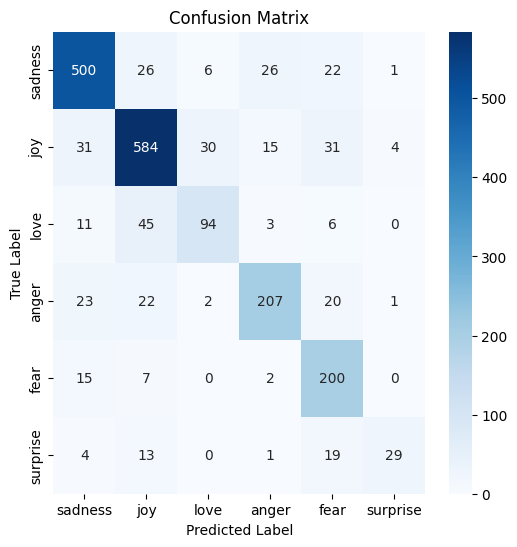

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        source = batch["input_ids"].to(device)
        target = batch["label"].to(device)

        encode = model.encode(source)
        prob = model.project(encode)

        pred_classes = torch.argmax(prob, dim=1)
        predictions.extend(pred_classes.cpu().numpy())
        true_labels.extend(target.cpu().numpy())


accuracy = np.mean(np.array(predictions) == np.array(true_labels))
print(f"Test Accuracy: {accuracy:.4f}")


def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
plot_confusion_matrix(predictions, true_labels, labels)



